In [1]:
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from html import unescape
import re
import spacy
from titlecase import titlecase
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
# load data
processed_path = "./processed_data.parquet"
df = pd.read_parquet(processed_path)

# load vocab
vocab_df = pd.read_csv("./vocab.csv")
vocab = {word: idx for word, idx in zip(vocab_df["word"], vocab_df["id"])}
reverse_vocab = {idx: word for word, idx in vocab.items()}  # get reverse vocab

pad_idx = vocab['<pad>']  
unk_idx = vocab['<unk>']
sos_idx = vocab['<start>']
eos_idx = vocab['<end>']

In [3]:
# check data type
print(df['title_seq'].dtype)

row_example = df.iloc[0]
print("row_example['title_seq']: ", row_example['title_seq'])
print("type of row_example['title_seq']: ", type(row_example['title_seq']))

object
row_example['title_seq']:  [    2   285   303     4  1355 13889   678     9     3]
type of row_example['title_seq']:  <class 'numpy.ndarray'>


In [4]:
def collate_fn(batch):
    """
    batch: List of (input_seq, target_seq)
    """
    input_seqs  = [torch.tensor(item[0], dtype=torch.long) for item in batch]
    target_seqs = [torch.tensor(item[1], dtype=torch.long) for item in batch]

    # padding to the max length in batch
    padded_inputs = pad_sequence(input_seqs,
                                 batch_first=True,
                                 padding_value=pad_idx)

    padded_targets = pad_sequence(target_seqs,
                                  batch_first=True,
                                  padding_value=pad_idx)

    return padded_inputs, padded_targets

In [5]:
class AGNewsDataset(Dataset):
    def __init__(self, dataframe, input_col="desc_seq", target_col="title_seq"):
        df = dataframe.reset_index(drop=True)

        # samples: List of (input_seq, target_seq)
        self.samples = []

        for idx, row in df.iterrows():
            input_seq = row[input_col].tolist()   # list[int]
            target_seq = row[target_col].tolist()   # list[int]

            # filter out short sequences
            if len(input_seq) >= 3 and len(target_seq) >= 3:
                self.samples.append((input_seq, target_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = AGNewsDataset(train_df, input_col="desc_seq", target_col="title_seq")
test_dataset  = AGNewsDataset(test_df,  input_col="desc_seq", target_col="title_seq")

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_dataloader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, collate_fn=collate_fn)

# check dataloader size
for batch_inputs, batch_targets in train_dataloader:
    print(batch_inputs.shape, batch_targets.shape)
    break

torch.Size([128, 39]) torch.Size([128, 12])


In [7]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, pad_idx=0, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx
        )
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0)
        )

    def forward(self, src):
        # src: [batch_size, src_len]
        embedded = self.embedding(src)  # -> [batch_size, src_len, embed_dim]

        outputs, hidden = self.gru(embedded)
        # outputs: [batch_size, src_len, hidden_dim] 
        # hidden: [num_layers, batch_size, hidden_dim]

        return hidden

In [8]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, pad_idx=0, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx
        )
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0)
        )
        # project to vocab size
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_step, hidden):
        """
        input_step: [batch_size], representing the token index
        hidden: [num_layers, batch_size, hidden_dim]
        """
        embedded = self.embedding(input_step)  # -> [batch_size, embed_dim]
        embedded = embedded.unsqueeze(1)

        output, hidden = self.gru(embedded, hidden)
        # output: [batch_size, 1, hidden_dim]
        # hidden: [num_layers, batch_size, hidden_dim]

        prediction = self.fc_out(output.squeeze(1))  # -> [batch_size, vocab_size]

        return prediction, hidden

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, eos_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        src: [batch_size, src_len] (desc_seq)
        trg: [batch_size, trg_len] (title_seq)
        teacher_forcing_ratio: probability to use teacher forcing
        """

        batch_size = src.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.vocab_size

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)

        hidden = self.encoder(src)
        # hidden: [num_layers, batch_size, hidden_dim]

        # 2. the first input to the decoder is the <sos> token
        input_step = trg[:, 0]  

        for t in range(1, trg_len):
            output, hidden = self.decoder(input_step, hidden)
            # output: [batch_size, vocab_size]
            outputs[:, t, :] = output

            # get the highest predicted token
            pred_token = output.argmax(1)  # [batch_size]

            use_teacher_forcing = (torch.rand(1).item() < teacher_forcing_ratio)
            if use_teacher_forcing:
                # use the ground-truth token as the next input to the decoder
                input_step = trg[:, t]
            else:
                # use the predicted token as the next input to the decoder
                input_step = pred_token

        return outputs

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparameters
vocab_size = 37943
embed_dim = 300            
hidden_dim = 256         
num_layers = 2          
num_epochs = 50
dropout=0.3

In [11]:
encoder = Encoder(vocab_size, embed_dim, hidden_dim, num_layers, pad_idx, dropout)
decoder = Decoder(vocab_size, embed_dim, hidden_dim, num_layers, pad_idx, dropout)
model = Seq2Seq(encoder, decoder, sos_idx, eos_idx, device).to(device)

# decrease learning rate by 0.5 every 10 epochs
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx) 
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [12]:
train_losses = []
val_losses = []

best_val_loss = float("inf")
best_epoch = -1

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    train_loss = 0.0

    for batch_inputs, batch_targets in tqdm(train_dataloader,
                                            desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        outputs = model(batch_inputs, batch_targets, teacher_forcing_ratio=max(0.5 - epoch*0.01, 0.1))
        # outputs: [batch_size, seq_len, vocab_size]

        # discard the <start> token
        outputs_reshaped = outputs[:, 1:].contiguous().view(-1, vocab_size)
        targets_reshaped = batch_targets[:, 1:].contiguous().view(-1)

        loss = criterion(outputs_reshaped, targets_reshaped)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_inputs, batch_targets in tqdm(test_dataloader,
                                                desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            outputs = model(batch_inputs, batch_targets, teacher_forcing_ratio=0.0)
            outputs_reshaped = outputs[:, 1:].contiguous().view(-1, vocab_size)
            targets_reshaped = batch_targets[:, 1:].contiguous().view(-1)

            loss = criterion(outputs_reshaped, targets_reshaped)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if (epoch+1) >= 40 and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch+1
        torch.save(model.state_dict(), "best_GRU.pt")
        print(f"  [Info] New best val loss: {best_val_loss:.4f}. Model saved at epoch {best_epoch}.")

    scheduler.step()

Epoch 1/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.95it/s]


Epoch [1/50] - Train Loss: 7.1236, Val Loss: 6.7172, LR: 0.001000


Epoch 2/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.53it/s]


Epoch [2/50] - Train Loss: 6.3026, Val Loss: 6.2718, LR: 0.001000


Epoch 3/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.92it/s]


Epoch [3/50] - Train Loss: 5.7477, Val Loss: 5.9923, LR: 0.001000


Epoch 4/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.48it/s]


Epoch [4/50] - Train Loss: 5.3075, Val Loss: 5.8418, LR: 0.001000


Epoch 5/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.48it/s]


Epoch [5/50] - Train Loss: 4.9434, Val Loss: 5.7691, LR: 0.001000


Epoch 6/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.81it/s]


Epoch [6/50] - Train Loss: 4.6389, Val Loss: 5.7458, LR: 0.001000


Epoch 7/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.83it/s]


Epoch [7/50] - Train Loss: 4.3686, Val Loss: 5.7446, LR: 0.001000


Epoch 8/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.00it/s]


Epoch [8/50] - Train Loss: 4.1385, Val Loss: 5.7716, LR: 0.001000


Epoch 9/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.20it/s]


Epoch [9/50] - Train Loss: 3.9335, Val Loss: 5.8009, LR: 0.001000


Epoch 10/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.69it/s]


Epoch [10/50] - Train Loss: 3.7511, Val Loss: 5.8451, LR: 0.001000


Epoch 11/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.70it/s]


Epoch [11/50] - Train Loss: 3.4339, Val Loss: 5.8376, LR: 0.000500


Epoch 12/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.73it/s]


Epoch [12/50] - Train Loss: 3.2911, Val Loss: 5.8780, LR: 0.000500


Epoch 13/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.92it/s]


Epoch [13/50] - Train Loss: 3.1912, Val Loss: 5.9218, LR: 0.000500


Epoch 14/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.37it/s]


Epoch [14/50] - Train Loss: 3.0956, Val Loss: 5.9577, LR: 0.000500


Epoch 15/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.82it/s]


Epoch [15/50] - Train Loss: 3.0224, Val Loss: 5.9966, LR: 0.000500


Epoch 16/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.73it/s]


Epoch [16/50] - Train Loss: 2.9455, Val Loss: 6.0383, LR: 0.000500


Epoch 17/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.95it/s]


Epoch [17/50] - Train Loss: 2.8639, Val Loss: 6.0855, LR: 0.000500


Epoch 18/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.41it/s]


Epoch [18/50] - Train Loss: 2.7945, Val Loss: 6.1296, LR: 0.000500


Epoch 19/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.03it/s]


Epoch [19/50] - Train Loss: 2.7266, Val Loss: 6.1735, LR: 0.000500


Epoch 20/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.06it/s]


Epoch [20/50] - Train Loss: 2.6623, Val Loss: 6.2144, LR: 0.000500


Epoch 21/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.74it/s]


Epoch [21/50] - Train Loss: 2.5147, Val Loss: 6.2307, LR: 0.000250


Epoch 22/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.37it/s]


Epoch [22/50] - Train Loss: 2.4512, Val Loss: 6.2620, LR: 0.000250


Epoch 23/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 11.95it/s]


Epoch [23/50] - Train Loss: 2.4119, Val Loss: 6.2913, LR: 0.000250


Epoch 24/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.13it/s]


Epoch [24/50] - Train Loss: 2.3773, Val Loss: 6.3168, LR: 0.000250


Epoch 25/50 [Val]: 100%|██████████| 176/176 [00:15<00:00, 11.57it/s]


Epoch [25/50] - Train Loss: 2.3428, Val Loss: 6.3527, LR: 0.000250


Epoch 26/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.46it/s]


Epoch [26/50] - Train Loss: 2.3097, Val Loss: 6.3808, LR: 0.000250


Epoch 27/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.28it/s]


Epoch [27/50] - Train Loss: 2.2779, Val Loss: 6.4100, LR: 0.000250


Epoch 28/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.54it/s]


Epoch [28/50] - Train Loss: 2.2490, Val Loss: 6.4297, LR: 0.000250


Epoch 29/50 [Val]: 100%|██████████| 176/176 [00:13<00:00, 12.77it/s]


Epoch [29/50] - Train Loss: 2.2205, Val Loss: 6.4554, LR: 0.000250


Epoch 30/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.51it/s]


Epoch [30/50] - Train Loss: 2.1926, Val Loss: 6.4821, LR: 0.000250


Epoch 31/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.53it/s]


Epoch [31/50] - Train Loss: 2.1214, Val Loss: 6.5040, LR: 0.000125


Epoch 32/50 [Val]: 100%|██████████| 176/176 [00:13<00:00, 12.59it/s]


Epoch [32/50] - Train Loss: 2.0890, Val Loss: 6.5258, LR: 0.000125


Epoch 33/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.46it/s]


Epoch [33/50] - Train Loss: 2.0735, Val Loss: 6.5410, LR: 0.000125


Epoch 34/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.18it/s]


Epoch [34/50] - Train Loss: 2.0559, Val Loss: 6.5559, LR: 0.000125


Epoch 35/50 [Val]: 100%|██████████| 176/176 [00:13<00:00, 12.76it/s]


Epoch [35/50] - Train Loss: 2.0418, Val Loss: 6.5779, LR: 0.000125


Epoch 36/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.15it/s]


Epoch [36/50] - Train Loss: 2.0235, Val Loss: 6.5973, LR: 0.000125


Epoch 37/50 [Val]: 100%|██████████| 176/176 [00:13<00:00, 12.59it/s]


Epoch [37/50] - Train Loss: 2.0137, Val Loss: 6.6077, LR: 0.000125


Epoch 38/50 [Val]: 100%|██████████| 176/176 [00:13<00:00, 12.59it/s]


Epoch [38/50] - Train Loss: 2.0010, Val Loss: 6.6222, LR: 0.000125


Epoch 39/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.56it/s]


Epoch [39/50] - Train Loss: 1.9822, Val Loss: 6.6402, LR: 0.000125


Epoch 40/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.55it/s]


Epoch [40/50] - Train Loss: 1.9695, Val Loss: 6.6559, LR: 0.000125
  [Info] New best val loss: 6.6559. Model saved at epoch 40.


Epoch 41/50 [Val]: 100%|██████████| 176/176 [00:13<00:00, 12.61it/s]


Epoch [41/50] - Train Loss: 1.9348, Val Loss: 6.6657, LR: 0.000063


Epoch 42/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.37it/s]


Epoch [42/50] - Train Loss: 1.9200, Val Loss: 6.6764, LR: 0.000063


Epoch 43/50 [Val]: 100%|██████████| 176/176 [00:13<00:00, 12.68it/s]


Epoch [43/50] - Train Loss: 1.9096, Val Loss: 6.6848, LR: 0.000063


Epoch 44/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.41it/s]


Epoch [44/50] - Train Loss: 1.8997, Val Loss: 6.6950, LR: 0.000063


Epoch 45/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.40it/s]


Epoch [45/50] - Train Loss: 1.8933, Val Loss: 6.7043, LR: 0.000063


Epoch 46/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.30it/s]


Epoch [46/50] - Train Loss: 1.8847, Val Loss: 6.7174, LR: 0.000063


Epoch 47/50 [Val]: 100%|██████████| 176/176 [00:13<00:00, 12.64it/s]


Epoch [47/50] - Train Loss: 1.8763, Val Loss: 6.7244, LR: 0.000063


Epoch 48/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.57it/s]


Epoch [48/50] - Train Loss: 1.8653, Val Loss: 6.7297, LR: 0.000063


Epoch 49/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.39it/s]


Epoch [49/50] - Train Loss: 1.8585, Val Loss: 6.7445, LR: 0.000063


Epoch 50/50 [Val]: 100%|██████████| 176/176 [00:14<00:00, 12.55it/s]

Epoch [50/50] - Train Loss: 1.8499, Val Loss: 6.7544, LR: 0.000063


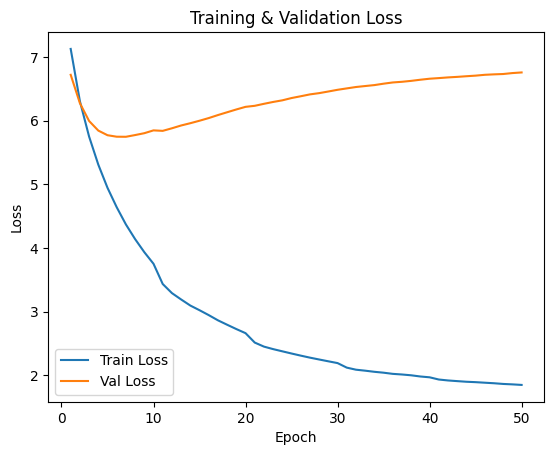

In [13]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [14]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

def clean_text(text):
    text = unescape(str(text))
    text = re.sub(r'<\/?[a-zA-Z_]+\b[^>]*>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'[<>]', '', text)

    text = text.replace('"', "'")
    allowed_punct = r"!?.,:;'"
    text = re.sub(fr"[^\w\s{allowed_punct}]", '', text)
    text = re.sub(r"\s+([!?,.])\s+", r" \1 ", text)
    text = re.sub(r"\s{2,}", " ", text).strip()
    return text

def normalize_text(text, is_title=False):
    if is_title:
        text = re.sub(r'\b([A-Z]{2,})\b', r'<KEEP_CAPS>\1</KEEP_CAPS>', text)
        text = titlecase(text.lower())
        text = re.sub(r'<KEEP_CAPS>(.*?)</KEEP_CAPS>', lambda m: m.group(1).upper(), text)
        return text
    else:
        return text.lower()

def spacy_tokenize(text, nlp):
    doc = nlp(text)  
    punct_set = {".", ",", "!", "?", ":", ";", "'"}
    tokens = []
    for token in doc:
        tok_text = token.text.strip()
        if not tok_text:
            continue
        if token.is_stop:
            continue
        if '_' in tok_text:
            continue
        if tok_text in punct_set:
            tokens.append(tok_text)
            continue
        if re.match(r'^[a-z0-9]+$', tok_text) and len(tok_text) >= 2:
            tokens.append(tok_text)
    return tokens

def text_to_sequence(tokens, vocab):
    return [vocab.get('<start>', 1)] \
           + [vocab.get(tok, vocab.get('<unk>', 1)) for tok in tokens] \
           + [vocab.get('<end>', 1)]

def process_inference_desc(text, vocab, nlp):
    # 1) clean
    text = clean_text(text)
    # 2) normalize (desc => is_title=False)
    text = normalize_text(text, is_title=False)
    # 3) spacy tokenize
    tokens = spacy_tokenize(text, nlp)
    # 4) map to sequence with <start> / <end>
    seq = text_to_sequence(tokens, vocab)
    return seq


In [15]:
def greedy_decode(model, src_tensor, max_len=30, sos_idx=2, eos_idx=3):
    model.eval()
    with torch.no_grad():
        hidden = model.encoder(src_tensor)  # -> [num_layers, batch_size=1, hidden_dim]
        batch_size = src_tensor.size(0)

        input_step = torch.tensor([sos_idx]*batch_size, dtype=torch.long, device=src_tensor.device)

        decoded_tokens = []
        for _ in range(max_len):
            output, hidden = model.decoder(input_step, hidden)
            # output: [batch_size, vocab_size] => [1, vocab_size]
            next_token = output.argmax(dim=1)  
            decoded_tokens.append(next_token.item())
            if next_token.item() == eos_idx:
                break
            input_step = next_token

        return decoded_tokens

def convert_ids_to_text(id_list, reverse_vocab):
    special_tokens = set(["<pad>", "<unk>", "<start>", "<end>"])
    words = []
    for idx in id_list:
        w = reverse_vocab.get(idx, "<unk>")
        # filter out special tokens
        if w not in special_tokens:
            words.append(w)
    return " ".join(words)

In [17]:
test_text_1 = "tokyo ap a lunar orbiter that japan had planned to launch this year could face further delays, possibly until next year or later, because of a funding shortfall and problems developing the probe's informationgathering capabilities, japan's space agency said wednesday. the japan aerospace exploration agency, or jaxa, released a report to a governmentrun commission explaining expected delays to the launch of the 135 million lunara probe..."
test_text_2 = "advanced micro devices inc.'s amd inc.'s 90nanometer notebook processors are on their way to customers, according to a research note published by goldman sachs co. thursday.advertisementintroducing ibm eserver p5 systems.powered by ibms most advanced 64bit microprocessor power5tm, p5 systems can run unix and linux simultaneously. learn more about eserver p5 systems."

for i, test_text in enumerate([test_text_1, test_text_2], start=1):
    # 1) convert text to sequence
    seq = process_inference_desc(test_text, vocab, nlp)

    # 2) convert to tensor
    src_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)

    # 3) greedy decoding
    sos_idx = vocab["<start>"]
    eos_idx = vocab["<end>"]
    decoded_ids = greedy_decode(model, src_tensor, max_len=30,
                                sos_idx=sos_idx, eos_idx=eos_idx)

    # 4) convert ids to text
    pred_title = convert_ids_to_text(decoded_ids, reverse_vocab)

    print(f"===== Input {i} =====")
    print("Original text (desc):", test_text)
    print("Predicted Title:", pred_title)


===== Input 1 =====
Original text (desc): tokyo ap a lunar orbiter that japan had planned to launch this year could face further delays, possibly until next year or later, because of a funding shortfall and problems developing the probe's informationgathering capabilities, japan's space agency said wednesday. the japan aerospace exploration agency, or jaxa, released a report to a governmentrun commission explaining expected delays to the launch of the 135 million lunara probe...
Predicted Title: japan lunar delays lunar
===== Input 2 =====
Original text (desc): advanced micro devices inc.'s amd inc.'s 90nanometer notebook processors are on their way to customers, according to a research note published by goldman sachs co. thursday.advertisementintroducing ibm eserver p5 systems.powered by ibms most advanced 64bit microprocessor power5tm, p5 systems can run unix and linux simultaneously. learn more about eserver p5 systems.
Predicted Title: , athlon , athlon athlon 64 3000
